In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import StandardScaler 
#from sklearn.svm import LinearSVC

#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#from sklearn import mixture, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import SelectFromModel
#from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
#from sklearn.feature_selection import SelectKBest, f_classif
#from sklearn.covariance import empirical_covariance

# import scipy
import json 
import random
import numpy as np
#import itertools 
#import sys
#import os
#import matplotlib as mpl
# from scipy import linalg
import pickle
from collections import defaultdict


# Remove all the un-necessary warnings
# import warnings
# warnings.filterwarnings('ignore')
multitarget_data_path = 'Data/CONAN-master/Multitarget-CONAN/Multitarget-CONAN.json'
combined_data_path = 'Data/combined_data.csv'

In [34]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [13]:
with open(combined_data_path, 'r', encoding='utf8') as f:
    combined = pd.read_csv(f).to_dict()

In [74]:
combined['HATE_SPEECH'][5339]
word_tokenize(_)

['1-800-slap-a-hoe']

In [88]:
combined['HATE_SPEECH'][6909]
word_tokenize(_)

['I', "'m", 'Hun-gry']

In [37]:
import re
def utils_preprocess_text(text: str, flg_stemm=False, flg_lemm=False, lst_stopwords=None):
    '''
    Code from https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
    Preprocess a string.
    :parameter
        :param text: string - text to process
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitization is to be applied
    :return
        cleaned text
    '''
    
    # clean (convert to lowercase and remove punctuations and   
    # characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatization (convert the word into root word)
    if flg_lemm == True:
        lem = WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    # back to string from list
    text = " ".join(lst_text)
    return text

In [45]:

utils_preprocess_text(combined['HATE_SPEECH'][6909])

'im hungry'

In [46]:
# preprocessing: remove symbols, divide into tweets and labels
tweets = [] # these arrays are aligned by index; tweet[i] has label[i]
labels = []
for tweet, label in zip(combined['HATE_SPEECH'].values(), combined['CLASS'].values()):
    #print(str(label) + ': ' + tweet)
    
    #tweet_tokens = word_tokenize(tweet)
    #if len(tweet_tokens) == 1:
    #    continue # this one tweet messes things up later
    #tweet = ' '.join(word.lower() for word in tweet_tokens if word.isalnum())

    tweet = utils_preprocess_text(tweet)

    tweets.append(tweet)
    labels.append(label)


In [47]:
target_types = ['Disabled', 'Jews', 'LGBT+', 'Migrants', 'Muslims', 'POC', 'Women', 'Other/Mixed', 'None']

### Embeddings

#### Tf-idf

In [48]:
embedding = 'tfidf'

In [49]:

#TF-IDF Features-F1
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# max and min are cutoffs for document frequency 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                                   max_df = 0.75, min_df=5, 
                                   max_features=10000)

# TF-IDF feature matrix
docs = tfidf_vectorizer.fit_transform(tweets)

In [50]:
with open('Models/Embeddings/tfidf_vectorizer', 'wb+') as f:
    pickle.dump(tfidf_vectorizer, f)

#### Doc2Vec

In [31]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [32]:
embedding = 'd2v'

In [35]:
# clean data, format as TaggedDocument to work with Doc2Vec
sents = []
for id, tweet in enumerate(tweets):
    words = TaggedDocument([w for w in tweet.split(' ') if not w in stop_words], [id])
    sents.append(words)

"\nfor id, val in multi_target.items():\n    hate_text = val['HATE_SPEECH']\n    \n    # remove stopwords\n    words = TaggedDocument([w.lower() for w in hate_text.split(' ') if w.isalnum() and not w in stop_words], [id])\n    #words = TaggedDocument([w.lower() for w in hate_text.split(' ') if w.isalnum()], [id] )  # make lowercase, remove punctuation\n    \n    sents.append(words)\n"

In [38]:
d2v_model = Doc2Vec(documents=sents, min_count=1, window=10, vector_size=100, sample=1e-4, negative=5, workers=8)

In [39]:
num_epochs = 100
d2v_model.train(corpus_iterable=sents, total_examples=d2v_model.corpus_count, epochs=num_epochs)

save_name = f'd2v_{num_epochs}epochs_{d2v_model.vector_size}dim'
d2v_model.save('Models/Embeddings/' + save_name)

In [42]:
# find most similar tweets to given tweet
tweet_index = 2
most_similar = d2v_model.dv.most_similar(tweet_index)
print(tweets[tweet_index])
for (id, similarity) in most_similar:
    print(id)
    print(f'{similarity*100}% similar:', tweets[id])


foreigners on uk benefits leaps 41 in 5 years with over 400k now handed payouts this nonsense has got to stop
69
98.28548431396484% similar: foreigners on uk benefits leaps 41 in 5 years with over 400k now handed payouts this nonsense has got to stop
104
97.06794023513794% similar: foreigners on uk benefits leaps 41 in 5 years with over 400k now handed payouts this nonsense has got to stop
84
96.85047268867493% similar: foreigners on uk benefits leaps 41 in 5 years with over 400k now handed payouts this nonsense has got to stop
6
96.15724682807922% similar: foreigners on uk benefits leaps 41 in 5 years with over 400k now handed payouts this nonsense has got to stop
118
95.89678645133972% similar: foreigners on uk benefits leaps 41 in 5 years with over 400k now handed payouts this nonsense has got to stop
74
95.590078830719% similar: foreigners on uk benefits leaps 41 in 5 years with over 400k now handed payouts this nonsense has got to stop
114
93.96886229515076% similar: foreigners on

In [43]:
d2v_model = Doc2Vec.load('Models/Embeddings/d2v_100epochs_100dim')

In [44]:
docs = [d2v_model.dv[i] for i in range(len(d2v_model.dv))]
#print(docs)

#### BERT

Based on [this tutorial](https://towardsdatascience.com/build-a-bert-sci-kit-transformer-59d60ddd54a5)

In [107]:
from transformers import BertTokenizer, BertModel
import torch
embedding = 'BERT'

In [108]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [109]:
#sent = multi_target['0']['HATE_SPEECH']
sent = tweets[0]
print(sent)
#sent = ' '.join([word for word in sent.split(' ') if word.isalnum() and not word in stop_words])
sent = word_tokenize(sent)
sent = ' '.join([word.lower() for word in sent if word.isalnum() and not word in stop_words])
print(sent)

maybe the un could talk to those asian and african nations responsible for 90 of the pollution in the oceans instead of insisting on this bullshit about climate change
maybe un could talk asian african nations responsible 90 pollution oceans instead insisting bullshit climate change


In [110]:
remove_stopwords = False

def get_sent_embedding(sent: str):
    if remove_stopwords:
        sent = ' '.join(word for word in sent.split() if not word in stop_words)
    
    tokenized = bert_tokenizer.encode_plus(sent, add_special_tokens=True)['input_ids']
    attention = [1] * len(tokenized)

    tokenized = torch.tensor(tokenized).unsqueeze(0)
    attention = torch.tensor(attention).unsqueeze(0)

    embedding = bert_model(tokenized, attention)
    return embedding[0][:, 0, :].squeeze()

with torch.no_grad():
    embeddings = torch.stack([get_sent_embedding(tweet) for tweet in tweets])

In [111]:
# save embeddings
with open('Models/Embeddings/bert', 'wb+') as f:
    pickle.dump(embeddings, f)

In [ ]:
# load embeddings
with open('Models/Embeddings/bert', 'rb') as f:
    embeddings = pickle.load(f)

In [112]:
docs = embeddings

#### GLoVe

In [61]:
embedding = 'glove'

In [62]:
glove_path = 'Data/glove.6B.100d.txt'

In [63]:
glove_embeddings = []
word_to_index = defaultdict(lambda: -1) # return index -1 on key error 
with open(glove_path, 'r') as f:
    for i, line in enumerate(f):
        word, *vector = line.rstrip().split(' ')
        vector = np.array([float(v) for v in vector])
        glove_embeddings.append(vector)
        word_to_index[word] = i

In [94]:
# create an embedding for unknown words by averaging all glove embeddings in vocab file
unknown_vec = np.mean(glove_embeddings, axis=0)

In [95]:
glove_embeddings.append(unknown_vec)

In [ ]:
remove_stopwords = False

# simple average of each word embedding
def get_sent_embedding(sent: str):
    #sent = sent.lower()
    #sent = word_tokenize(sent)
    #print(sent)
    # convert each word to index into glove embeddings list and
    # remove stopwords if needed
    sent_tokens = [word_to_index[word] for word in sent if (remove_stopwords and not word in stop_words) or not remove_stopwords]
    #print(sent_tokens)
    #sent_tokens = [i for i in sent_tokens if i != -1] # remove any words not in vocab
    

    sent_embedding = sum(glove_embeddings[i] for i in sent_tokens)/len(sent_tokens)
    return sent_embedding

#sent = multi_target['10']['HATE_SPEECH']
sent = tweets[6908]
print(sent)
print(get_sent_embedding(sent))


In [ ]:
docs = [get_sent_embedding(tweet) for tweet in tweets]

### Training

In [51]:
X = docs
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

#### Logistic Regression

In [52]:
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_preds = model.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)
acc = accuracy_score(y_test, y_preds)
mod_train = model.score(X_train, y_train) 

print('Logistic Regression Train accuracy {:.3f}%'.format(mod_train * 100)) 
print('Logistic Regression Test accuracy {:.3f}%'.format(acc * 100)) 

confusion = confusion_matrix(y_test, y_preds)
print('Confusion matrix: ')
print(confusion) 

              precision    recall  f1-score   support

           0       1.00      0.76      0.87        55
           1       0.98      0.92      0.95       128
           2       0.97      0.82      0.89       112
           3       0.94      0.97      0.95       186
           4       0.95      0.96      0.95       273
           5       0.98      0.77      0.87        79
           6       0.97      0.95      0.96       117
           7       1.00      0.41      0.58        59
           8       0.91      1.00      0.95       825

    accuracy                           0.94      1834
   macro avg       0.97      0.84      0.89      1834
weighted avg       0.94      0.94      0.93      1834

Logistic Regression Train accuracy 96.181%
Logistic Regression Test accuracy 93.511%
Confusion matrix: 
[[ 42   0   2   0   0   1   1   0   9]
 [  0 118   0   0   0   0   0   0  10]
 [  0   0  92   0   2   0   3   0  15]
 [  0   0   0 180   2   0   0   0   4]
 [  0   0   0   4 262   0   0   0  

In [52]:
for i in range(9):
    print(i, ':', labels.count(i))

0 : 220
1 : 594
2 : 617
3 : 957
4 : 1335
5 : 352
6 : 662
7 : 266
8 : 4163


<AxesSubplot:>

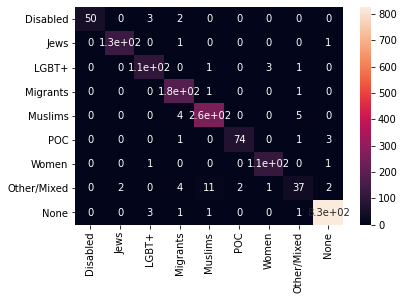

In [116]:
sns.heatmap(confusion, annot=True, xticklabels=target_types, yticklabels=target_types)

In [53]:
with open(f'Models/MultiClassifier/LR_model_{embedding}_report.txt', 'a') as f:
    f.write(report)
    f.write('Logistic Regression Train accuracy {:.3f}%\n'.format(mod_train * 100)) 
    f.write('Logistic Regression Test accuracy {:.3f}%\n'.format(acc * 100)) 

    if embedding == 'd2v':
        f.write('\n')
        f.write('d2v info:\n')
        f.write('  Epochs: {}\n'.format(d2v_model.epochs))
        f.write('  Dimensions: {}\n'.format(d2v_model.vector_size))
    f.write('\n')


In [54]:
with open(f'Models/MultiClassifier/LR_model_{embedding}', 'wb+') as f:
    pickle.dump(model, f)

#### Random Forest

In [118]:
RF = RandomForestClassifier()
RF.fit(X_train,y_train)
y_preds = RF.predict(X_test)
report = classification_report(y_test, y_preds)
acc = accuracy_score(y_test, y_preds)
RF_train = RF.score(X_train, y_train) 

print(report)

print('Random Forest Train accuracy {:.3f}%'.format(RF_train * 100)) 
print('Random Forest Test accuracy {:.3f}%'.format(acc * 100)) 

confusion = confusion_matrix(y_test, y_preds)
print('Confusion matrix: ')
print(confusion) 

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        55
           1       0.98      0.85      0.91       128
           2       0.93      0.84      0.88       111
           3       0.82      0.94      0.87       185
           4       0.89      0.97      0.93       269
           5       0.94      0.62      0.75        79
           6       0.91      0.91      0.91       115
           7       0.97      0.53      0.68        59
           8       0.95      1.00      0.97       832

    accuracy                           0.92      1833
   macro avg       0.93      0.81      0.86      1833
weighted avg       0.93      0.92      0.92      1833

Random Forest Train accuracy 99.932%
Random Forest Test accuracy 92.144%
Confusion matrix: 
[[ 37   0   1   6   0   0   4   1   6]
 [  0 109   3   2   7   1   1   0   5]
 [  0   0  93   6   2   0   3   0   7]
 [  0   0   0 174   4   1   0   0   6]
 [  0   0   0   5 260   0   0   0   4]
 [  0   

<AxesSubplot:>

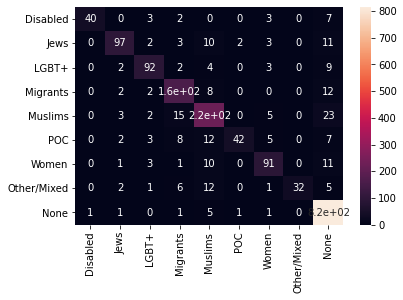

In [55]:
sns.heatmap(confusion, annot=True, xticklabels=target_types, yticklabels=target_types)

In [119]:
with open(f'Models/MultiClassifier/RF_model_{embedding}_report.txt', 'a') as f:
    f.write(report)
    f.write('Random Forest Train accuracy {:.3f}%\n'.format(RF_train * 100)) 
    f.write('Random Forest Test accuracy {:.3f}%\n'.format(acc * 100)) 

    if embedding == 'd2v':
        f.write('\n')
        f.write('d2v info:\n')
        f.write('  Epochs: {}\n'.format(d2v_model.epochs))
        f.write('  Dimensions: {}\n'.format(d2v_model.vector_size))
    f.write('\n')

#### Naive Bayes

In [120]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_preds = nb.predict(X_test)
report = classification_report(y_test, y_preds)
acc2 = accuracy_score(y_test, y_preds)
mod_train2 = model.score(X_train, y_train) 

print(report)

print('Naive Bayes Train accuracy {:.3f}%'.format(mod_train2 * 100)) 
print('Naive Bayes Test accuracy {:.3f}%'.format(acc2 * 100)) 

print('Confusion matrix: ')
print(confusion_matrix(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       0.96      0.80      0.87        55
           1       0.91      0.84      0.87       128
           2       0.90      0.77      0.83       111
           3       0.84      0.86      0.85       185
           4       0.94      0.80      0.86       269
           5       0.75      0.73      0.74        79
           6       0.95      0.88      0.91       115
           7       0.22      0.47      0.30        59
           8       0.96      0.97      0.97       832

    accuracy                           0.88      1833
   macro avg       0.83      0.79      0.80      1833
weighted avg       0.90      0.88      0.89      1833

Naive Bayes Train accuracy 99.645%
Naive Bayes Test accuracy 87.670%
Confusion matrix: 
[[ 44   0   0   2   0   1   0   5   3]
 [  0 107   0   1   1   3   0  10   6]
 [  1   3  85   5   0   3   2   5   7]
 [  0   2   0 159   2   3   0  13   6]
 [  0   2   2   7 214   1   0  41   2]
 [  1   1   

In [121]:
with open(f'Models/MultiClassifier/NB_model_{embedding}_report.txt', 'a') as f:
    f.write(report)
    f.write('Naive Bayes Train accuracy {:.3f}%\n'.format(RF_train * 100)) 
    f.write('Naive Bayes Test accuracy {:.3f}%\n'.format(acc * 100)) 

    if embedding == 'd2v':
        f.write('\n')
        f.write('d2v info:\n')
        f.write('  Epochs: {}\n'.format(d2v_model.epochs))
        f.write('  Dimensions: {}\n'.format(d2v_model.vector_size))
    f.write('\n')